# Simpsons Detector
## Creating dataset

The following Python notebook refers the [simpsons detector post](http://zachmoshe.com).

This notebook shows how to generate the dataset (both training and test sets) given the folders with Google Images images.

Some classes are from my `general` and `simpsons` modules. They are available in [my github repo](https://github.com/zachmoshe/datalab)

In [1]:
import numpy as np
import sklearn
import scipy
import pickle as pickle
import glob
import os
import moviepy
import skimage.measure
import seaborn as sns 
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
from general.plotting import *
from general.datasets import *

Using TensorFlow backend.


## Load training images

Loads all images from folders and performs the following:
* rescale to 300x300
* remove the background (images with 'noisy' background were filtered out)
* crop empty edges (leaves only the character in the middle of the frame)
* fill with np.nan instead of background

In [18]:
BASE_PATH = "/Users/zach/proj/datalab-data/simpsons/"

In [5]:
TRAINING_DATA_PATH = BASE_PATH + "preprocessing/training"
TEST_DATA_PATH = BASE_PATH + "preprocessing/test"
BACKGROUNDS_DIR = 'backgrounds'

directory_to_labels_mapping = {
    'bart': 'bart', 'marge': 'marge', 'homer': 'homer', 'lisa': 'lisa', 
}

def crop_empty_edges(img, mask):
    # assumes img is (r,w,3) and has a nan background.
    color_presence_rows = np.argwhere((mask != 0).any(axis=1) == True)[:,0]
    min_row, max_row = color_presence_rows[0], color_presence_rows[-1]
    
    color_presence_cols = np.argwhere((mask != 0).any(axis=0) == True)[:,0]
    min_col, max_col = color_presence_cols[0], color_presence_cols[-1]
    
    return img[min_row:max_row, min_col:max_col, :], mask[min_row:max_row, min_col:max_col]


def load_images(directory, max_size=(300,300), ignore_size=(300,300)):
    max_size = np.array(max_size)

    raw_images = []
    filenames = []
    images = []
    images_shapes = []
    labels = []
    for label_dir in glob.glob("{}/*".format(directory)):
        if label_dir == "{}/{}".format(TRAINING_DATA_PATH, BACKGROUNDS_DIR):
            continue
            
        base_label_dir = os.path.basename(label_dir)
        
        for filename in glob.glob("{}/*".format(label_dir)):
            # image pixels are 0-255
            img = scipy.misc.imread(filename, mode='RGB').astype(float)
            images_shapes.append(np.array([img.shape]))
            raw_images.append(img.copy())
            
            # skip small images
            if img.shape[0] < ignore_size[0] and img.shape[1] < ignore_size[1]:
                #print("skipping {}. shape={}".format(filename, img.shape))
                continue

            
            # remove background
            mask = np.ones(img.shape[:2])
            img2 = np.log((img-1.0001).mean(axis=2)) / np.log(2) // 0.5
            labeled_img = skimage.measure.label(img2, connectivity=1)
            mask[labeled_img == labeled_img[0,0]] = 0
            mask[labeled_img == labeled_img[0,-1]] = 0
            mask[labeled_img == labeled_img[-1,0]] = 0
            mask[labeled_img == labeled_img[-1,-1]] = 0

            img, mask = crop_empty_edges(img, mask)

            # scale down if too large
            resize_factor = (max_size / img.shape[:max_size.size]).min()
            img = scipy.misc.imresize(img, resize_factor, interp='lanczos').astype(float)
            mask = scipy.misc.imresize(mask, resize_factor, interp='nearest')

            # fill with zeros (blacks) to get to max_size
            full_img = np.empty(max_size.tolist() + [3,])
            full_img[:] = np.nan
            
            full_img[ (max_size[0] - img.shape[0])//2 : (max_size[0] - img.shape[0])//2 + img.shape[0], 
                      (max_size[1] - img.shape[1])//2 : (max_size[1] - img.shape[1])//2 + img.shape[1], : ]\
                    [mask>0] = img[mask>0]/255.0
            

            images.append(full_img[None,:])
            filenames.append(filename)
            
            label = directory_to_labels_mapping.get(base_label_dir, 'none')
            labels.append([label])

    images = np.concatenate(images)
    
    labels = np.concatenate(labels)
    shapes = np.concatenate(images_shapes)
    
    return images, filenames, labels, shapes, raw_images


In [6]:
all_images, all_filenames, all_labels, all_shapes, all_raw_images = load_images(TRAINING_DATA_PATH, max_size=(300,300), ignore_size=(300,300))

## Check for empty images

This might happen because `scipy.misc.imresize` doesn't handle well arrays that has only one value (all-zeros or all-ones). If it happened - don't bother fixing, just remove the image from the folder

In [7]:
# Should return an empty list
for i in np.argwhere(np.isnan(all_images).all(axis=(1,2,3))).flatten():
    print(all_filenames[i])

## Look at raw images shapes

Plots raw images sizes as a scatter chart just to see if there is anything unusual

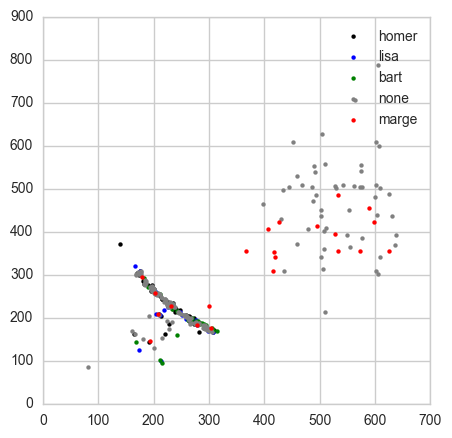

In [9]:
sns.set_style('whitegrid')
x = all_shapes[:,0] + np.random.random(all_shapes.shape[0])*10
y = all_shapes[:,1] + np.random.random(all_shapes.shape[0])*10
plt.figure(figsize=(5,5))
colors=['black', 'blue', 'green', 'gray', 'red', 'purple']
for idx,char in enumerate(set(all_labels)):
    plt.scatter(x[all_labels==char], y[all_labels==char], s=10, label=char, linewidth=0, c=colors[idx])

plt.legend(loc='best')

## Encode training labels

Uses `LabelEncoder` and `OneHotEncoder` to generate y vectors for every training image.

In [10]:
label_enc = sklearn.preprocessing.LabelEncoder()
label_enc.fit(all_labels)
oh_enc = sklearn.preprocessing.OneHotEncoder(sparse=False)
all_labels_oh = oh_enc.fit_transform(
    label_enc.transform(all_labels).reshape(-1,1)
)

none_label_index = label_enc.transform(['none'])[0]
# remove it (make all 'none' one-hot vectors equal [0, 0, ..., 0])
all_labels_oh = np.delete(all_labels_oh, none_label_index, axis=1)

## Show some training images exmaples

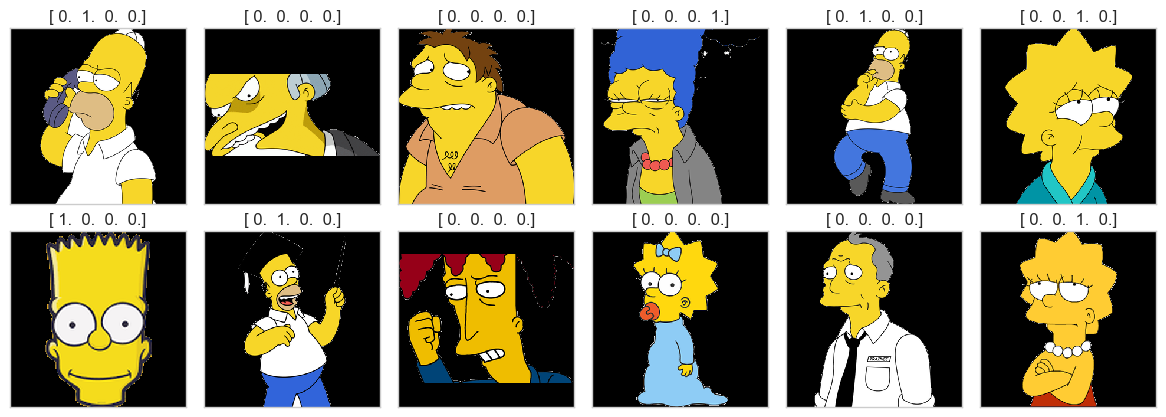

In [12]:
sample_idx = np.random.permutation(range(len(all_images)))
gridplot(all_images[sample_idx][:12], titles=all_labels_oh[sample_idx][:12])

In [13]:
print(pd.DataFrame([
        ["images"] + all_labels_oh.sum(axis=0).tolist() + [(all_labels_oh==0).all(axis=1).sum()],
    ], columns=["dataset", "bart", "homer", "lisa", "marge", "none"], dtype=int))
print("Total num of training set images: ", all_images.shape[0])

  dataset  bart  homer  lisa  marge  none
0  images    34     61    21     22   165
Total num of training set images:  303


---

# Load test images

This assumes we've already extracted test frames from episodes and send them to HeatIntelligence for tagging. It takes the responses text file, reads the relevant images, rescales them and create the dataset.

In [14]:
tagged_frames = pd.read_csv(BASE_PATH + "preprocessing/test/all-requests-responses.txt", names=["url", "characters", "certainty"])

In [15]:
tagged_frames['oh_enc'] = tagged_frames.characters.apply(
    lambda x: np.zeros((len(label_enc.classes_)-1)) if
        pd.isnull(x) else
        oh_enc.transform(label_enc.transform([ s if s in label_enc.classes_ else 'none' for s in x.split(",")])[:,None]).max(axis=0)[:-1]
)
tagged_frames['filename'] = BASE_PATH + "preprocessing/test/full-episodes-frames/" + tagged_frames.url.str.split("/").apply(lambda x:x[-1])

In [19]:
tagged_frames[:10]

In [20]:
test_labels = np.concatenate(tagged_frames.oh_enc.apply(lambda x: x[None,:]).values)


In [21]:
max_size = np.array([202,360])

test_imgs = np.zeros((tagged_frames.shape[0],) + tuple(max_size) + (3,))

for idx, filename in enumerate(tagged_frames.filename):
    img = scipy.misc.imread(filename, mode='RGB')
    resize_factor = (max_size / img.shape[:max_size.size]).min()
    img = scipy.misc.imresize(img, resize_factor, interp='lanczos')

    
    full_img = np.zeros(max_size.tolist() + [3,])
    test_imgs[idx, 
              (max_size[0] - img.shape[0])//2 : (max_size[0] - img.shape[0])//2 + img.shape[0], 
              (max_size[1] - img.shape[1])//2 : (max_size[1] - img.shape[1])//2 + img.shape[1], : ] = img/255.0


In [22]:
test_imgs.shape

(702, 202, 360, 3)

Look at all images with all ones (all characters). Sometimes that's a tagging mistake. I'm not going to fix it manually though.

In [23]:
i = np.argwhere((test_labels==1).all(axis=1)).flatten()

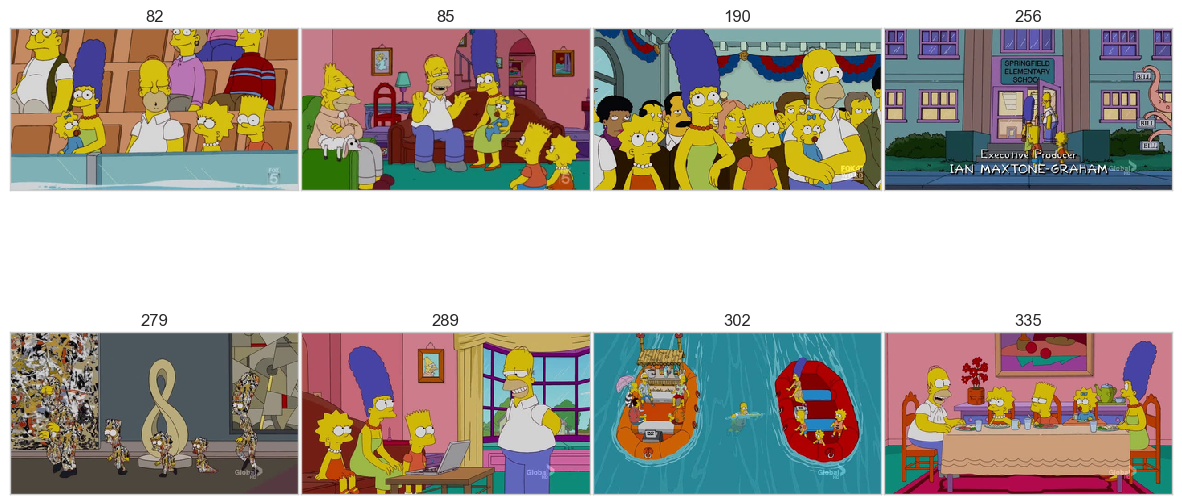

There are 20 all-characters images. Showing only first 8...


In [25]:
gridplot(test_imgs[i][:8], titles=i, num_cols=4)
print("There are {} all-characters images. Showing only first 8...".format(i.shape[0]))

In [27]:
# Just a sanity check
(test_imgs.shape, test_labels.shape)

((702, 202, 360, 3), (702, 4))

## Show test frames examples

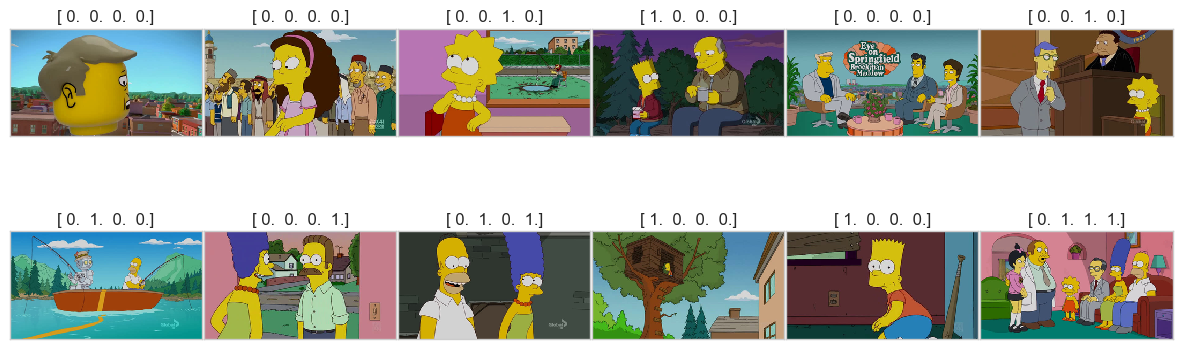

In [30]:
sample_inds = np.random.permutation(range(test_imgs.shape[0]))[:12]
gridplot(test_imgs[sample_inds], titles=test_labels[sample_inds])

# Create datasets

`Dataset` is my class that splits data into train/train-dev/dev/test

In [31]:
test_labels_classes = np.apply_along_axis(lambda l: ",".join(str(x) for x in l), axis=1, arr=test_labels)
all_labels_oh_classes = np.apply_along_axis(lambda l: ",".join(str(x) for x in l), axis=1, arr=all_labels_oh)

data = Datasets(all_images, all_labels_oh, X_test=test_imgs, y_test=test_labels, train_dev_split=0.25,
               stratify=(all_labels_oh_classes, test_labels_classes))

In [32]:
data.show()

train
  - X: (227, 300, 300, 3)
  - y: (227, 4)
train_dev
  - X: (76, 300, 300, 3)
  - y: (76, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


In [33]:
pd.DataFrame([
        ["train"] + data.train.y.sum(axis=0).tolist(),
        ["train_dev"] + data.train_dev.y.sum(axis=0).tolist(),
        ["dev"] + data.dev.y.sum(axis=0).tolist(),
        ["test"] + data.test.y.sum(axis=0).tolist()
    ], columns=["dataset", "bart", "homer", "lisa", "marge"], dtype=int)

,dataset,bart,homer,lisa,marge
0,train,25,46,16,16
1,train_dev,9,15,5,6
2,dev,74,101,65,65
3,test,73,102,65,64


# Save to file

In [139]:
import pickle
import gzip
import time

with gzip.GzipFile(BASE_PATH+"data/dataset.pickle.zip", 'wb') as f:
    pickle.dump(data, f)